# Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
!pip install nltk

In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from itertools import groupby

%matplotlib inline
pd.options.display.max_colwidth=500

In [3]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [4]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [5]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [6]:
## Here we add column scene_info to the test dataset
epsiode_scene_column = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = epsiode_scene_column

In [7]:
test_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene
0,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.",FEMALE,1350-7
1,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,...I've got pins and needles in my fingers.,MALE,1350-7
2,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,That's the cold.,FEMALE,1350-7
3,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,Yeah. It's all shutting down.,MALE,1350-7
4,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,It's just the cold.,FEMALE,1350-7
...,...,...,...,...,...,...,...
1762,1398,32,GEORGE STREET EXT NIGHT,JANE,I know. Now Ian come on. Everything's going to be alright. It is. It's going to be alright.,FEMALE,1398-32
1763,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,Night night baby. I love you.,FEMALE,1399-27
1764,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,OTHER,Love you too.,FEMALE,1399-27
1765,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,"Let's get that under your ankle shall we. Careful, alright? Night night darling. Love you.",FEMALE,1399-27


In [8]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [9]:
val_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
56,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,Who's that?,FEMALE,1350-18,heldout
57,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,Tanya! Tanya it's me. I wanna give Oscar a New Year kiss. Tan?,MALE,1350-18,heldout
58,1350,18,BRANNINGS' HOUSE INT NIGHT,SEAN,Right. I'll have a word.,MALE,1350-18,heldout
59,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,"No no no leave it, leave it. He ain't got a key. He'll go away. Do you want some crisps?",FEMALE,1350-18,heldout
60,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,"Who, who you got in there, Tan? Tan, I've got a right to know who my kids are being exposed to. I bet you ain't got anyone have ya? You're just sitting there with a bottle of wine all on your Jack, Tan?",MALE,1350-18,heldout
...,...,...,...,...,...,...,...,...
15268,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"I asked him to leave you. I asked him again and again. I begged him. And if he had. I'd have been with him. I'd have been with him now. So it might suit you to think that it was all Max but it wasn't, not really, not in the end.",FEMALE,1399-29,heldout
15269,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,Why you telling me all this eh?,FEMALE,1399-29,heldout
15270,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"Because I don't want you using Sean to punish him, I don't want you wrecking your family cause of me. I just, I just want it all over.",FEMALE,1399-29,heldout
15271,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,It is over. It's all over. Will you please just go home now and leave me alone.,FEMALE,1399-29,heldout


In [10]:
test_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene
0,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.",FEMALE,1350-7
1,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,...I've got pins and needles in my fingers.,MALE,1350-7
2,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,That's the cold.,FEMALE,1350-7
3,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,Yeah. It's all shutting down.,MALE,1350-7
4,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,It's just the cold.,FEMALE,1350-7
...,...,...,...,...,...,...,...
1762,1398,32,GEORGE STREET EXT NIGHT,JANE,I know. Now Ian come on. Everything's going to be alright. It is. It's going to be alright.,FEMALE,1398-32
1763,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,Night night baby. I love you.,FEMALE,1399-27
1764,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,OTHER,Love you too.,FEMALE,1399-27
1765,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,"Let's get that under your ankle shall we. Careful, alright? Night night darling. Love you.",FEMALE,1399-27


In [11]:
val_data.iloc[0, 6] == val_data.iloc[1, 6]

True

In [12]:
# if False:
#     # A simpler alternative to the above, but where a high split means some characters
#     # may be left out
#     print('Raw Data: ',np.shape(all_train_data))
#     idx = int(0.9 * np.shape(all_train_data)[0])
#     train_data = all_train_data[:idx]
#     val_data = all_train_data[idx:]
#     print('Train set: ',np.shape(train_data))
#     print('Validation set: ',np.shape(val_data))

In [13]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count, add_context):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    add_scene_info = {}
    row_idx = 0
    for line, name, gender, ep_scence, scene_info in zip(df.Line, df.Character_name, df.Gender, df.episode_scene, df.Scene_info):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
         
        if not name + '-' + ep_scence in add_scene_info:
            add_scene_info[name + '-' + ep_scence] = False
            
        if character_line_count[name]==max_line_count:
            continue
        ## Add scene info once for each character in each scene
        # if add_context:
        if add_scene_info[name + '-' + ep_scence] == False:
            character_docs[name] += str(scene_info) + " _EOL_ "
            add_scene_info[name + '-' + ep_scence] = True
            
        ## We add a corresponding line for each character anyway!
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
        
        
        # Adding Context
        if add_context:
            ## Check first row and add context (second line if it was applicable)
            if row_idx == 0:
                ## Check if current row and next row have identical ep_scene, as well as characters are different (unless one line add twice for one character)
                if ep_scence == df.iloc[row_idx + 1, 6] and name != df.iloc[row_idx + 1, 3]:
                    context_line =  df.iloc[row_idx + 1, 4]
                    character_docs[name] += str(context_line)   + " _EOL_ "  # adding an end-of-line token

            ## Check last row and add context (previous line if it was applicable)
            elif row_idx == len(df) - 1:
                ## Check if current row and previous row have identical ep_scene, as well as characters are different (unless one line add twice for one character)
                if ep_scence == df.iloc[row_idx - 1, 6] and name != df.iloc[row_idx - 1, 3]:
                    context_line =  df.iloc[row_idx + 1, 4]
                    character_docs[name] += str(context_line)   + " _EOL_ "  # adding an end-of-line token

            ## Check all other rows, and add previous or next line if it was applicable
            else:
                prev_ep_scence = df.iloc[row_idx - 1, 6]
                next_ep_scence = df.iloc[row_idx + 1, 6]

                prev_line = df.iloc[row_idx - 1, 4]
                next_line = df.iloc[row_idx + 1, 4]

                prev_name = df.iloc[row_idx - 1, 3]
                next_name = df.iloc[row_idx + 1, 3]

                if ep_scence == prev_ep_scence and name != prev_name:
                    character_docs[name] += str(prev_line)   + " _EOL_ "  # adding an end-of-line token
                if ep_scence == next_ep_scence and name != next_name:
                    character_docs[name] += str(next_line)   + " _EOL_ "  # adding an end-of-line token

            row_idx += 1

        
    print("lines per character", character_line_count)
    return character_docs

In [14]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360, add_context=1)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  4982
OTHER Number of Words:  5553
JACK Number of Words:  5098
RONNIE Number of Words:  4383
TANYA Number of Words:  5441
SEAN Number of Words:  4939
ROXY Number of Words:  4906
HEATHER Number of Words:  4677
MAX Number of Words:  5774
IAN Number of Words:  4896
JANE Number of Words:  4457
STACEY Number of Words:  4495
PHIL Number of Words:  4178
MINTY Number of Words:  4519
CHRISTIAN Number of Words:  4173
CLARE Number of Words:  4848
total words 77319


In [15]:
## Try document per character
## This one shows the list of each line
# print(train_character_docs['TANYA'].split('_EOL_'))
print(len(train_character_docs['TANYA'].split('_EOL_')))


579


In [16]:
!pip install contractions

In [17]:
# ## Remove Contractions

# import contractions

# example_text = "I'd like to tell you that if I were you, I'd do that again. I think you shouldn't do it since it's annoying."
# # List consisting of modified sentence
# modified_sentence = []   
# for word in example_text.split():
#   # using contractions.fix to expand the shortened words
#   modified_sentence.append(contractions.fix(word))  
   
# modified_sentence = ' '.join(modified_sentence)
# print('Original Text: ' + example_text)
# print('Modified Text: ' + modified_sentence)

In [18]:
# ## Lowercasing

# example_text = 'HeLLo TheRe GuYsssSsss!'
# modified_text = example_text.lower()
# print(modified_text)


In [19]:
# ## Replace all - with ' '

# example_text = 'These are hard-pronounced word and not---remembering'
# modified_text = re.sub('-', ' ' , example_text) 
# print(modified_text)

In [20]:
# ## Remove Punctuations

# example_text = "Th*!&%@$is is an ema!@)&*il from a well-(*^(known user with id: 1234567 _EOL_"
# ## Remove each punctutation chracter
# # modified_text = re.sub('[%s]' % re.escape(string.punctuation), '' , example_text) 
# modified_text = re.sub(r'[^\w\s]', '', example_text)
# ## Exclude all multiple white space to one
# modified_text = re.sub(' +', ' ', modified_text)
# modified_text


In [21]:
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
    

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    
    adj_tokens = []
    verb_tokens = []
    noun_tokens = []
    adv_tokens = []
    
    ## Remove Contractions
    # List consisting of modified sentence
    modified_text = []   
    for word in character_text.split():
      # using contractions.fix to expand the shortened words
      modified_text.append(contractions.fix(word))  
    modified_text = ' '.join(modified_text)
    
    ## Replace all - with ' '
    modified_text = re.sub('-', ' ' , modified_text) 
    
    ## Remove Punctuations
    modified_text = re.sub(r'[^\w\s]', '', modified_text)
    
    ## Exclude all multiple white space to one
    modified_text = re.sub(' +', ' ', modified_text)
    
    ## set of stop words from nltk corpus
    stop_words = set(stopwords.words('english'))
    
    ## Lemmization
    wordnet_lem = WordNetLemmatizer()
    
    ## Iterate for each sentence
    for line in modified_text.split('_EOL_'):
        # print('This is the sentence:')
        # print(line)
        ## Tokenizing
        tokenized_text = word_tokenize(line)
        
        ## POS tagger
        pos_res = nltk.pos_tag(tokenized_text)
        # print('This is POS:')
        # print(pos_res)
        # print('-------------------------------------')

        ## lemmatization and add word's lemma to the correspinding list, using obtained pos
        for token, pos in pos_res:
            ## Lowercasing
            token = token.lower()
            
            ## Remove Stop Words
            if token in stop_words:
                continue
            
            if pos.startswith('J'):
                adj_tokens.append(wordnet_lem.lemmatize(token, wordnet.ADJ))
            elif pos.startswith('V'):
                verb_tokens.append(wordnet_lem.lemmatize(token, wordnet.VERB))
            elif pos.startswith('R'):
                adv_tokens.append(wordnet_lem.lemmatize(token, wordnet.ADV))
            else: 
                noun_tokens.append(wordnet_lem.lemmatize(token, wordnet.NOUN))
          
        adj_tokens.append('_EOL_')
        verb_tokens.append('_EOL_')
        adv_tokens.append('_EOL_')
        noun_tokens.append('_EOL_')
    
    return adj_tokens + verb_tokens + adv_tokens + noun_tokens
        
    # final_tokens = [wordnet_lem.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_res]
    # print(final_tokens)
    # return final_tokens
    
    
    # tokens = character_text.split()   # just a simple tokenization, to be replaced
    # print(character_text.split())
    # return tokens

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
## Each instance in training_corpus is like: (character_name, [word1, word2, ..., _eol_, ..., wordn])
# print(training_corpus[7])

In [23]:
# from itertools import groupby

# a = ['_EOL_', '_EOL_', '_EOL_', 'ten', '_EOL_', '_EOL_', 'late', 'little', '_EOL_', '_EOL_', '_EOL_', '_EOL_', '_EOL_', '_EOL_', '_EOL_', 'much', 'good', '_EOL_', 'good',
#     '_EOL_', '_EOL_', '_EOL_', '_EOL_', 'predictable', '_EOL_', '_EOL_', 'Hello', "Duck", "Bear", '_EOL_', '_EOL_', '_EOL_', 'personal']
# [key for key, _group in groupby(a)]

# [list(group) for k, group in groupby([key for key, _group in groupby(a)], lambda x: x == "_EOL_") if not k]

        

In [24]:
def to_feature_vector_dictionary(character_doc):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    extra_features = []
    
    ## Remove consecutive _EOL_
    character_doc = [key for key, _group in groupby(character_doc)]
    
    ## Group the above list by _EOL_
    gp_by_eol = [list(group) for k, group in groupby(character_doc, lambda x: x == "_EOL_") if not k]
    
    # ## Adding 2-grams
    # for item in gp_by_eol:
    #     idx = 0
    #     while idx + 1 < len(item):
    #         extra_features.append(item[idx] + ' ' + item[idx+1])
    #         idx += 1 
    
    # ## Adding 3-grams
    # for item in gp_by_eol:
    #     idx = 0
    #     while idx + 2 < len(item):
    #         extra_features.append(item[idx] + ' ' + item[idx+1] + ' ' +item[idx+2])
    #         idx += 1 
    
    
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts:
            counts[feature] = 1
        else:
            counts[feature] += 1
            
    # Best for 2-grams
    retain_feature_per = 1
    ## Best for 3-grams & 2-grams + tf-idf without adding context
    # retain_feature_per = 0.70
    ## Best for context
    ## To be found
    del counts['_EOL_']
    ## Sort counts based on the number of count of each feature and select K best ones
    reduced_counts = dict(sorted(counts.items(), key=lambda x:x[1], reverse=True)[:int(retain_feature_per*len(counts))])
    
    return reduced_counts

In [25]:
from sklearn.decomposition import TruncatedSVD

corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()
svd = TruncatedSVD(n_components=16)



def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    # We use document feature matrix for computing idf here
    if fitting:
        tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix_tfidf = tfidf_transformer.transform(doc_feature_matrix)
    
    if fitting:
        svd.fit(doc_feature_matrix_tfidf)
    doc_feature_matrix_svd = svd.transform(doc_feature_matrix_tfidf)

    

    # return doc_feature_matrix_tfidf
    return doc_feature_matrix_svd

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [26]:
training_feature_matrix.shape

(16, 16)

In [27]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40, add_context=1)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]

val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  611
MAX Num of Words:  878
SEAN Num of Words:  539
SHIRLEY Num of Words:  735
OTHER Num of Words:  528
STACEY Num of Words:  529
RONNIE Num of Words:  508
JACK Num of Words:  385
PHIL Num of Words:  525
IAN Num of Words:  539
JANE Num of Words:  496
ROXY Num of Words:  431
HEATHER Num of Words:  470
MINTY Num of Words:  512
CHRISTIAN Num of Words:  556
CLARE Num of Words:  435
total words 8677


In [28]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [29]:
val_feature_matrix.shape

(16, 16)

In [30]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [31]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    # print('this is train feature matrix:')
    # print(train_feature_matrix.shape)
    # print('this is test feature matrix:')
    # print(test_feature_matrix.shape)
    ## The number of features depends on to_feature_vector_dictionary function (By now, before trying word2vec)
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        # fm_1 = test_feature_matrix.toarray()[idx]
        fm_1 = test_feature_matrix[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            # fm_2 = train_feature_matrix.toarray()[j]
            fm_2 = train_feature_matrix[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            ## This if stores the similarity of test character with vector space of same character in training
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            ## This one below stores a similarity of test character with all other characters and keep it
            ## all_sim = {char1: similarity of test with char1, char2: similarity of test with char2, ..., char16: similarity of test with char16}
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        print('This is sorted similarities for target: ', target)
        print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        print('This is ranking for target: ',target)
        print(ranking)
        print('---------------------------------------------------')
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [32]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [33]:
## Testing on evaluation set
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

This is sorted similarities for target:  CHRISTIAN
[('JANE', 0.9284072996813761), ('CHRISTIAN', 0.9101092863501739), ('CLARE', 0.8410024009738493), ('IAN', 0.837978229356782), ('RONNIE', 0.7407231462793116), ('PHIL', 0.7354518443090281), ('ROXY', 0.7260187025713492), ('SEAN', 0.7249973143024776), ('MINTY', 0.7098060202602003), ('STACEY', 0.7055942481188475), ('JACK', 0.7024884970155428), ('SHIRLEY', 0.6930303451864519), ('HEATHER', 0.6907248209521178), ('TANYA', 0.6636619144013403), ('MAX', 0.6614953382257762), ('OTHER', 0.5847104425033041)]
This is ranking for target:  CHRISTIAN
{'JANE': 1, 'CHRISTIAN': 2, 'CLARE': 3, 'IAN': 4, 'RONNIE': 5, 'PHIL': 6, 'ROXY': 7, 'SEAN': 8, 'MINTY': 9, 'STACEY': 10, 'JACK': 11, 'SHIRLEY': 12, 'HEATHER': 13, 'TANYA': 14, 'MAX': 15, 'OTHER': 16}
---------------------------------------------------
This is sorted similarities for target:  CLARE
[('CLARE', 0.9499360125065045), ('RONNIE', 0.8316074426422133), ('JACK', 0.8263299313287531), ('ROXY', 0.82457752

In [34]:
df

,doc1,doc2,similarity
0,CHRISTIAN,CHRISTIAN,0.910109
1,CHRISTIAN,CLARE,0.841002
2,CHRISTIAN,HEATHER,0.690725
3,CHRISTIAN,IAN,0.837978
4,CHRISTIAN,JACK,0.702488
...,...,...,...
251,TANYA,ROXY,0.691818
252,TANYA,SEAN,0.928300
253,TANYA,SHIRLEY,0.736285
254,TANYA,STACEY,0.681911


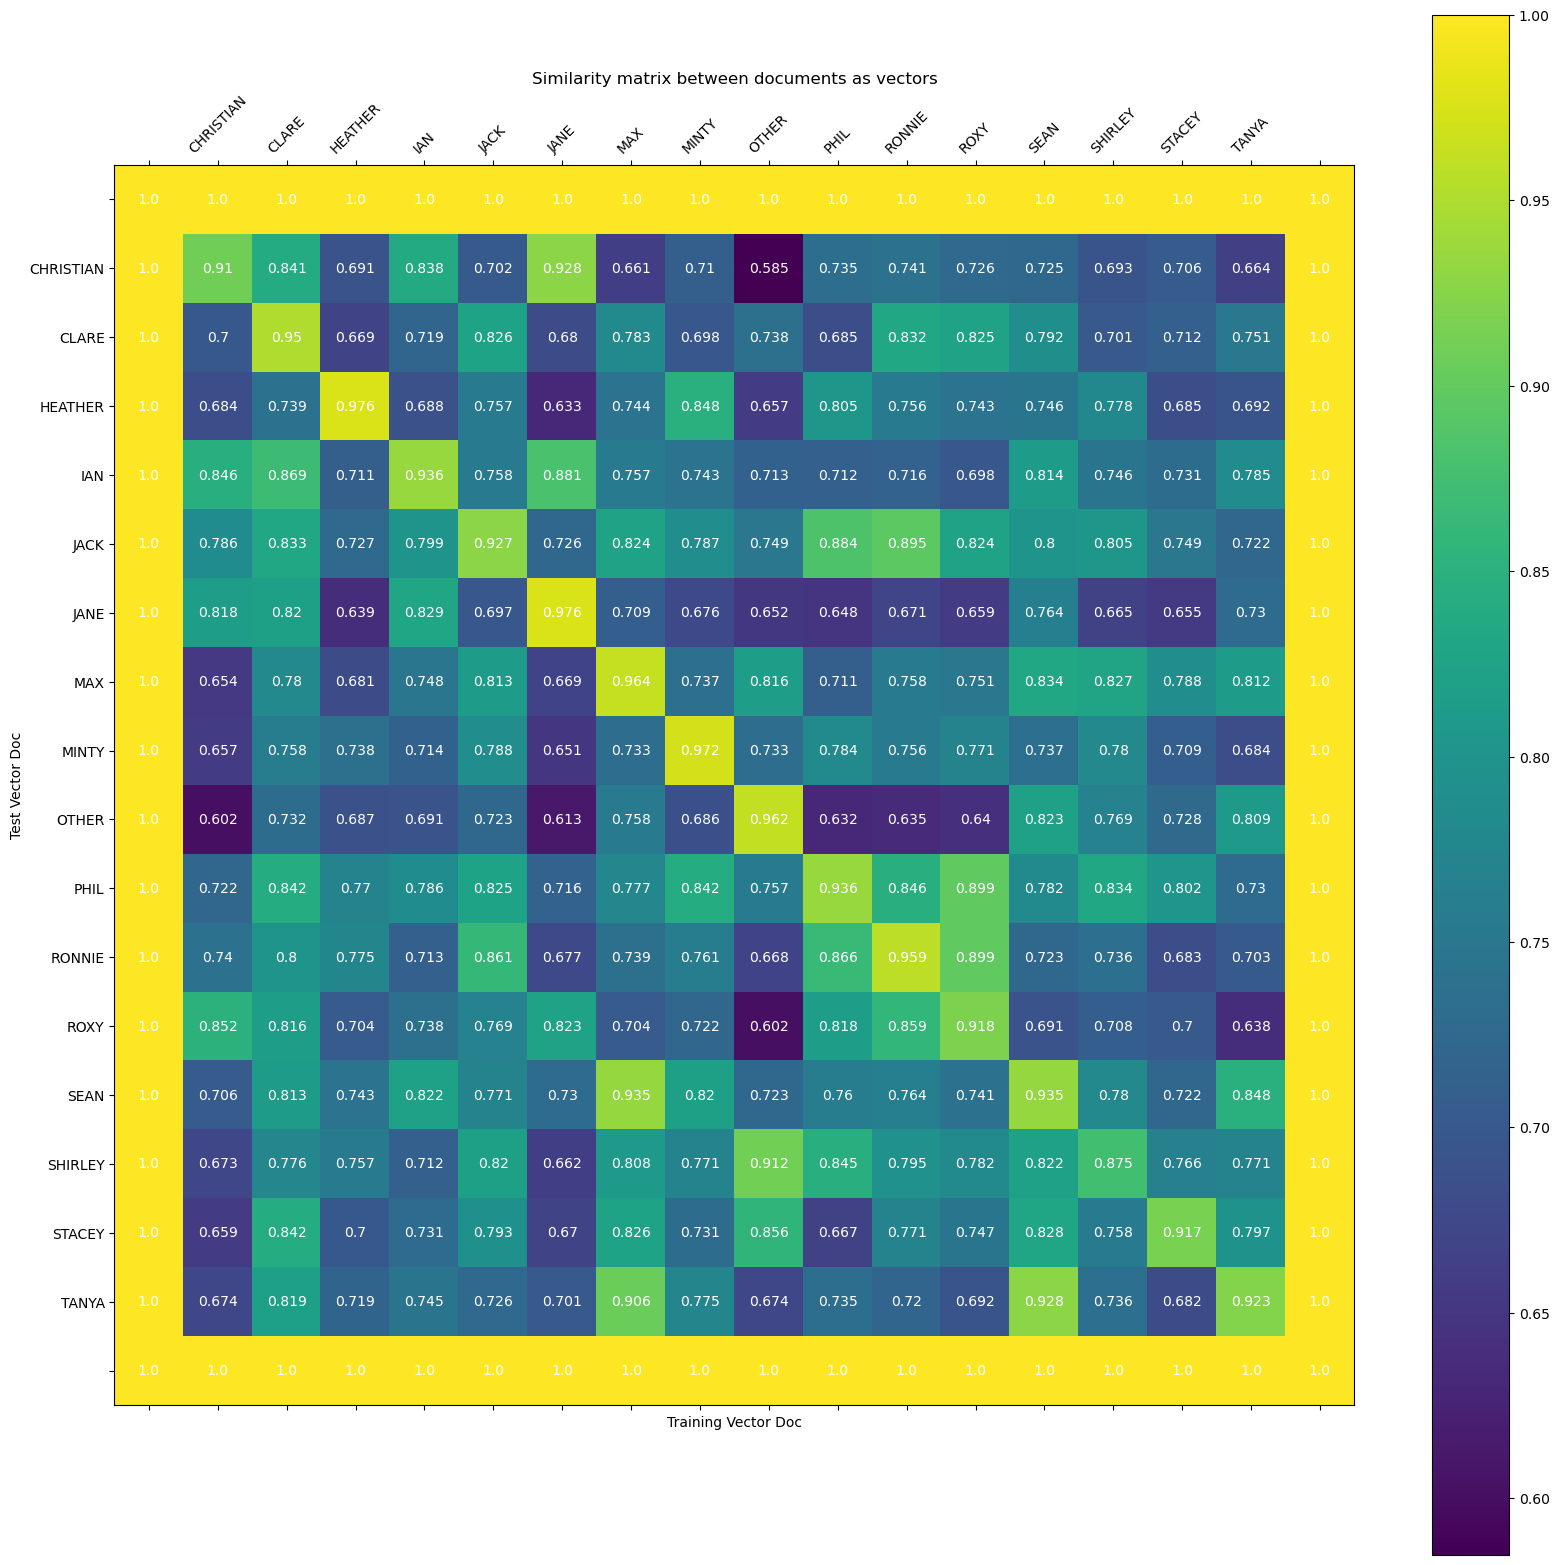

In [35]:
plot_heat_map_similarity(df)

# Error Analysis

Miss-classified characters are: SHIRLEY (rank 6), SEAN (rank 4), MAX (rank 2), JACK (rank 2), CLARE (rank 2), CHRISTIAN (rank 2)

In [36]:
def analyse_similarity(train_corpus, test_corpus, ranks_name, target):
    fig, axs = plt.subplots(nrows=len(ranks_name)+1, figsize=(20, 48))
    
    ## Test feaatures for targets here
    char_doc = [features for character, features in test_corpus if character == target][0]
    ## The values are sorted
    char_features_test = to_feature_vector_dictionary(char_doc)
    
    cos_similarity = []
    ## Iteration of all other character in training that we want to compare with them
    for idx, rn in enumerate(ranks_name):
        char_doc = [features for character, features in train_corpus if character == rn][0]
        ## The values are sorted
        char_features_train = to_feature_vector_dictionary(char_doc)
        ## Find all common features of this rank and test features
        train_count_features = 0
        test_count_features = 0
        for key in char_features_train:
            train_count_features += char_features_train[key]**2
        for key in char_features_test:
            test_count_features += char_features_test[key]**2
            
        labels = []
        train_cf = []
        test_cf = []
        for key in char_features_train:
            if key in char_features_test:
                train_feature_density = char_features_train[key] / np.sqrt(train_count_features)
                test_feature_density = char_features_test[key] / np.sqrt(test_count_features)
                labels.append(key)
                train_cf.append(train_feature_density)
                test_cf.append(test_feature_density)
        
        x = np.arange(len(labels))  # the label locations
        width = 0.3  # the width of the bars
        rects1 = axs[idx].bar(x - width/2, train_cf, width, label= rn + ' in training')
        rects2 = axs[idx].bar(x + width/2, test_cf, width, label=target + ' in test')
        # Add some text for labels, title and custom x-axis tick labels, etc.
        axs[idx].set_ylabel('Feature Density')
        axs[idx].set_xticks(x, labels, rotation=90)
        axs[idx].legend()
        
        cos_similarity.append(np.sum(np.array(train_cf) * np.array(test_cf)))
        
    labels = ['Similarity']
    x = np.arange(len(labels))  # the label locations
    width = 0.05  # the width of the bars
    rects1 = axs[-1].bar(x - width, cos_similarity[0], width, label= ranks_name[0])
    rects2 = axs[-1].bar(x, cos_similarity[1], width, label= ranks_name[1])
    rects2 = axs[-1].bar(x + width, cos_similarity[2], width, label= ranks_name[2])
    axs[-1].set_ylabel('Cosine Similarity')
    axs[-1].set_xticks(x, labels)
    axs[-1].legend()
    # axs[idx+len(ranks_name)].axhline(y=0, color = 'green')
    axs[-1].set_title('Cosine similarity of training characters with {} (test)'.format(target))
    # axs[idx+len(ranks_name)].legend()
        
    plt.show()       
        
    

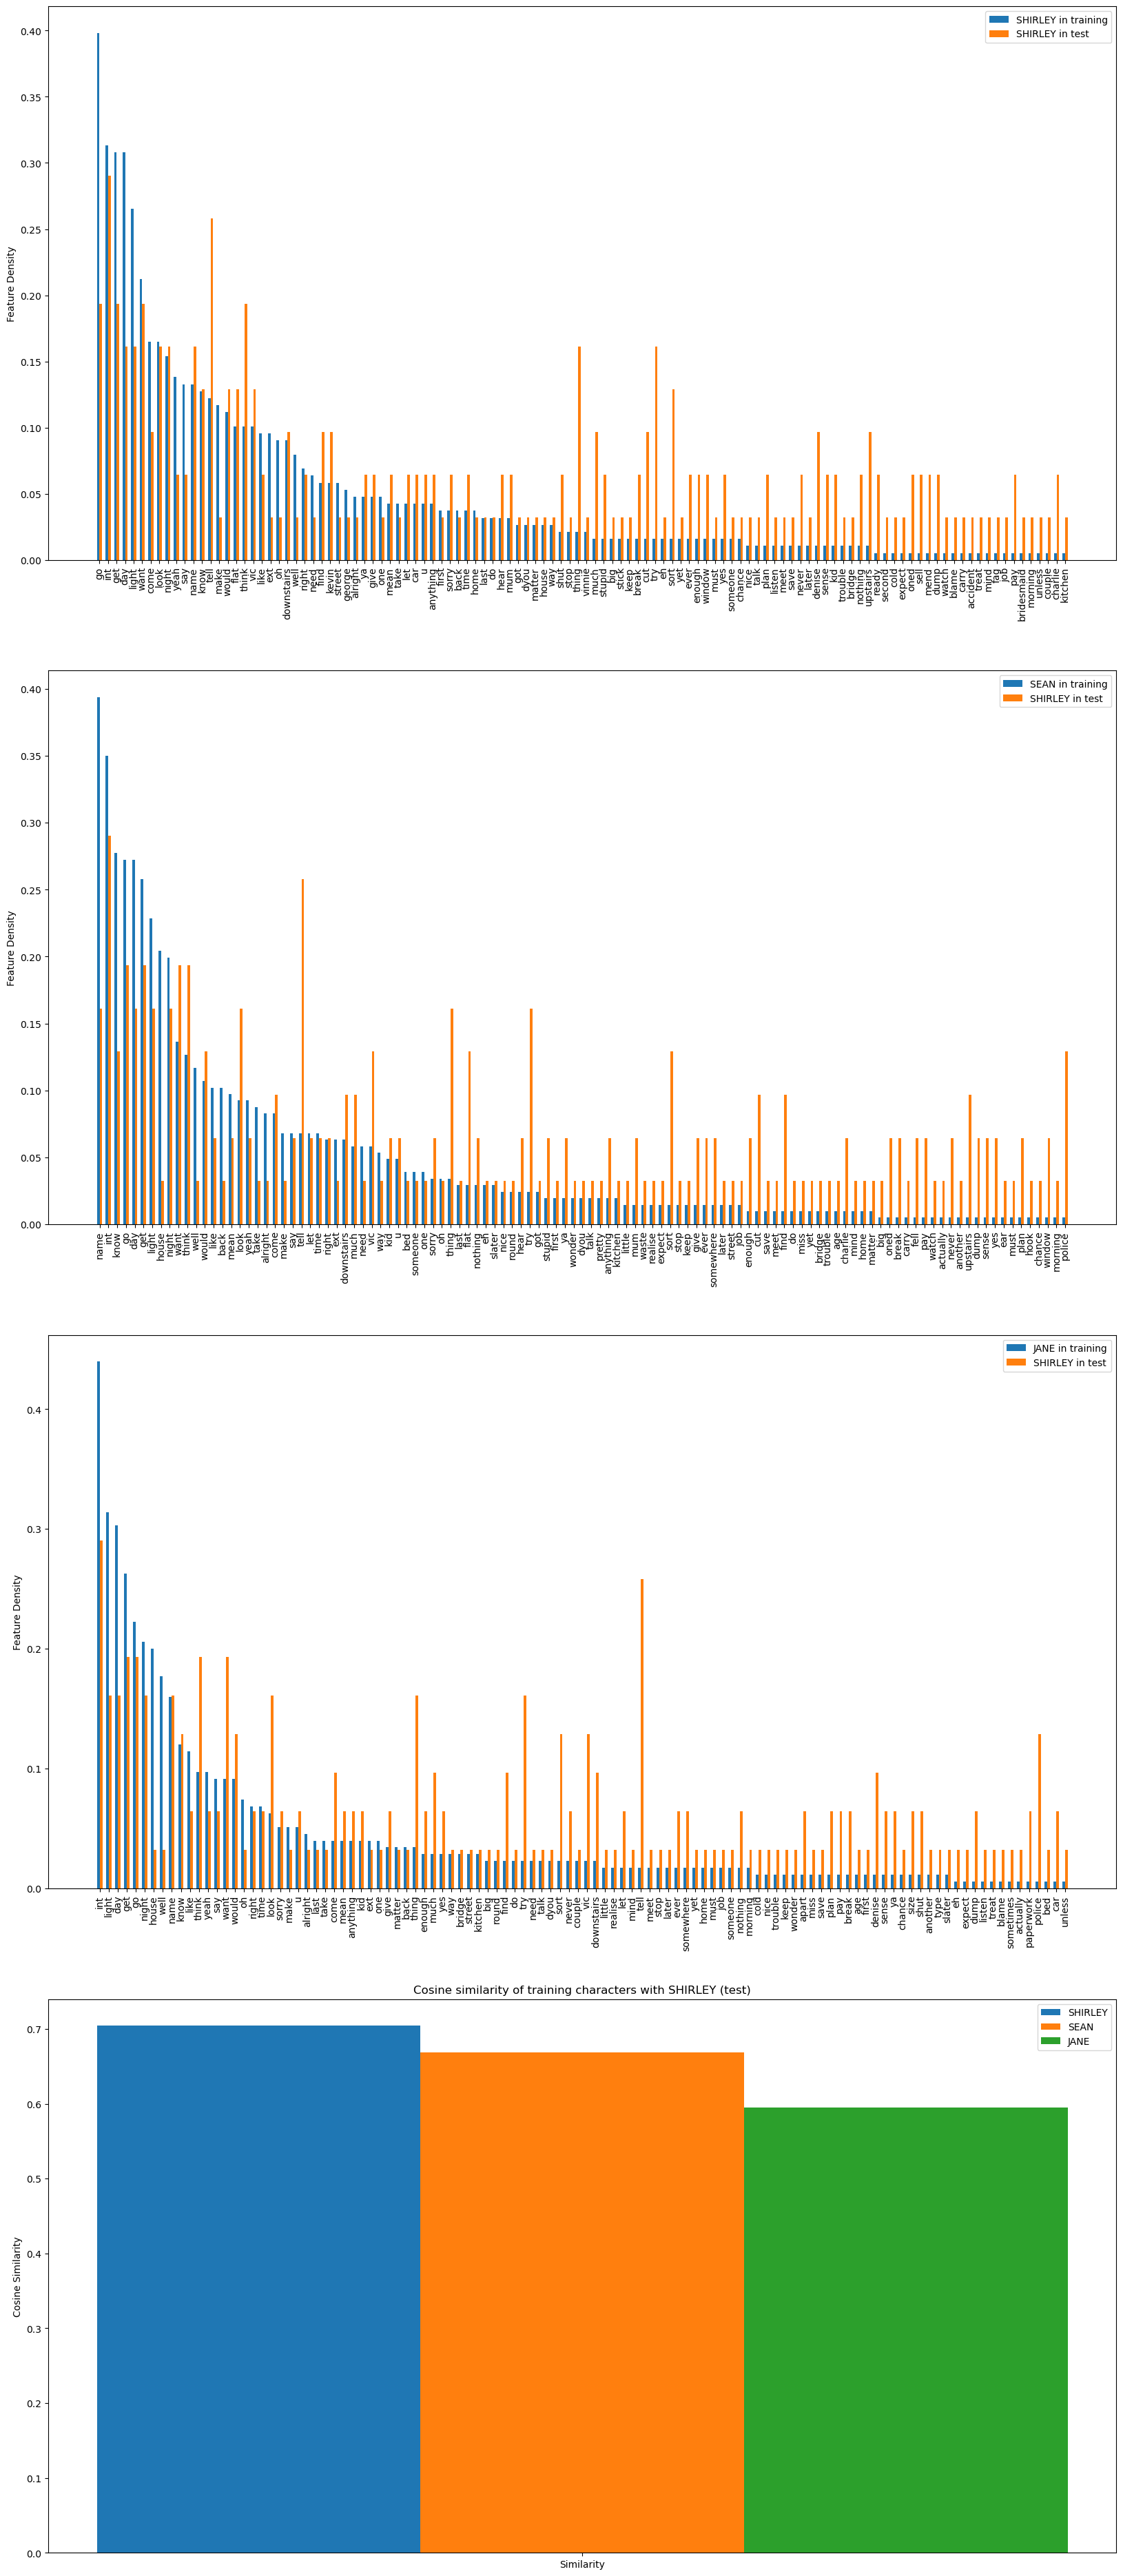

In [37]:
analyse_similarity(training_corpus, val_corpus, ['SHIRLEY', 'SEAN', 'JANE'], 'SHIRLEY')

# Final Test

In [38]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400, add_context=1)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()
svd = TruncatedSVD(n_components=16)


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40, add_context=1)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  5770
OTHER Number of Words:  6058
JACK Number of Words:  5479
RONNIE Number of Words:  4857
TANYA Number of Words:  6030
SEAN Number of Words:  5517
ROXY Number of Words:  5307
HEATHER Number of Words:  5128
MAX Number of Words:  6634
IAN Number of Words:  5465
JANE Number of Words:  4964
STACEY Number of Words:  4927
PHIL Number of Words:  4693
MINTY Number of Words:  4922
CHRISTIAN Number of Words:  4752
CLARE Number of Words:  5384
total words 85887
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters:  